## 导入python包

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from matplotlib_inline import backend_inline
import os
import zipfile, tarfile, hashlib, requests
import time
from functools import partial
import math

## code from d2l

In [12]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('.', 'data')):
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

DATA_HUB['airfoil'] = (DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    def add(self, x, y):
        # 这一部分的目的是，序列化输入x，y
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        # 初始化主类的数据存储
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        # 逐一添加数据
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        # 依次画线，此处应当注意x，y的线的数量超过fmts的长度时，应当自定义self.fmts
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def evaluate_loss(net, data_iter, loss):
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = torch.reshape(y, out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

def use_svg_display():
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

DATA_PATH = './data'

def get_dataloader_workers():
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root=DATA_PATH, train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root=DATA_PATH, train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
    
def evaluate_accuracy(net, data_iter): #@save
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    set_figsize()
    plot([f_line, results], [[f(x) for x in f_line], [f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

def train_2d(trainer, steps=20, f_grad=None):
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):
    set_figsize()
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1),
                          np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def evaluate_accuracy_gpu(net, data_iter, device=None): 
    if isinstance(net, torch.nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)#创建一个累加器，包含2个要累加的元素
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())#把每一组数据预测结果正确的个数和长度累加
    return metric[0] / metric[1]


## homework code for sec3

epoch 20, x1: -0.057646, x2: -0.000073


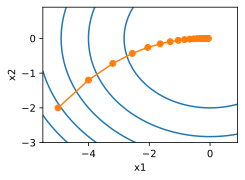

In [4]:
#T1
f_2d = lambda x, y: x**2 + 2*y**2
f_2d_grad = lambda x, y: (2*x, 4*y)
def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return  (x1-eta*g1, x2-eta*g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

epoch 20, x1: -0.607883, x2: -0.023058


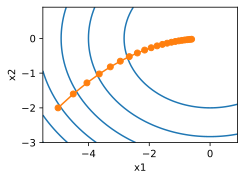

In [5]:
eta = 0.05
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

epoch 20, x1: -5.000000, x2: -6973568802.000000


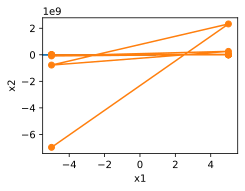

In [6]:
eta = 1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

In [10]:
#T2
# 需要，要找到导数的零点
# log_2(1/精度)级别

def dichotomy(a, b, f, f_grad, tol):
    mid = a+(b-a)/2
    if b-a <= tol:
        print(f"approximate minimum value in x={mid} and y={f(mid)}")
        return mid, f(mid)
    else:
        fg_a, fg_mid ,fg_b = f_grad(a), f_grad(mid), f_grad(b)
        if fg_a >= 0:
            print(f"exact minimum value in x={a} and y={f(a)}")
            return a, f(a)
        elif fg_b <= 0:
            print(f"exact minimum value in x={b} and y={f(b)}")
            return b, f(b)
        else:
            if fg_mid > 0:
                return dichotomy(a, mid, f, f_grad, tol)
            elif fg_mid < 0:
                return dichotomy(mid, b, f, f_grad, tol)
            else:
                print(f"exact minimum value in x={mid} and y={f(mid)}")
                return mid, f(mid)

f = lambda x: np.log(np.exp(x)+np.exp(-2*x-3))
fg = lambda x: (np.exp(x)-2*np.exp(-2*x-3))/np.exp(f(x))

dichotomy(-3, 3, f, fg, 0.001)

approximate minimum value in x=-0.7686767578125 and y=-0.36348575653628956


(-0.7686767578125, -0.36348575653628956)

epoch 20, x1: -0.057646, x2: -1.921502


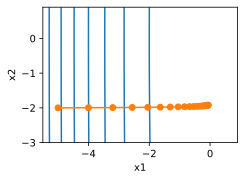

In [12]:
#T3
f_2d = lambda x, y: x**2 + 0.01*y**2
f_2d_grad = lambda x, y: (2*x, 0.02*y)
eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

epoch 20, x1: 0.000000, x2: 0.000000


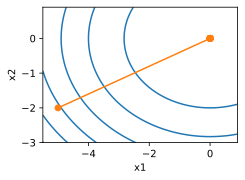

In [17]:
#T4
def newtow_simple(x1, x2, s1, s2, f_grad, f_hess):
    fg = f_grad(x1, x2)
    fh = f_hess(x1, x2)
    return x1-eta*fg[0]/fh[0][0], x2 - eta*fg[1]/fh[1][1], 0, 0

eta=1
f = lambda x,y: x**2 + 2*y**2
f_g = lambda x,y: (2*x, 4*y)
f_hess = lambda x,y: ((2, 0), (0, 4))
show_trace_2d(f, train_2d(partial(newtow_simple, f_hess=f_hess), f_grad=f_g))

epoch 20, x1: -0.000005, x2: -0.000002


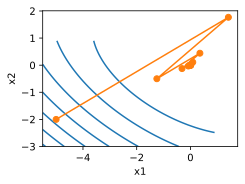

In [19]:
#T5 坐标旋转45度，简单牛顿的二阶导会丢失非对角线hessian矩阵的信息
eta=1
f = lambda x,y: x**2 + 2*y**2 + math.sqrt(2)*x*y
f_g = lambda x,y: (2*x + math.sqrt(2)*y, 4*y + math.sqrt(2)*x)
f_hess = lambda x,y: ((2, math.sqrt(2)), (math.sqrt(2), 4))
show_trace_2d(f, train_2d(partial(newtow_simple, f_hess=f_hess), f_grad=f_g))

epoch 20, x1: -0.001526, x2: 0.000790


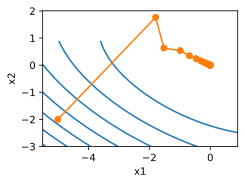

In [22]:
eta = 0.25
show_trace_2d(f, train_2d(gd_2d, f_grad=f_g))

## homework code for sec4

epoch 50, x1: -0.009362, x2: 0.042530


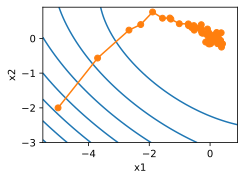

In [24]:
def constant_lr():
    return 1

eta = 0.1
lr = constant_lr
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)


show_trace_2d(f, train_2d(sgd, steps=50, f_grad=f_g))

epoch 50, x1: -1.829209, x2: 0.568716


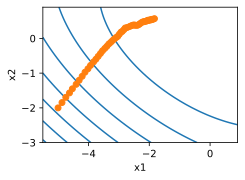

In [25]:
eta = 0.01
show_trace_2d(f, train_2d(sgd, steps=50, f_grad=f_g))

epoch 50, x1: -84032715904113676599659855872.000000, x2: -162338741089991079457611317248.000000


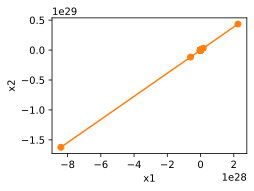

In [26]:
eta = 1
show_trace_2d(f, train_2d(sgd, steps=50, f_grad=f_g))

## homework code for sec5

loss: 0.280, 0.012 sec/epoch


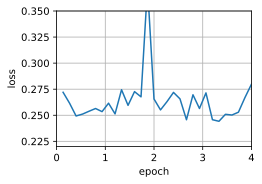

In [4]:
#T1
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

loss: 0.245, 0.010 sec/epoch


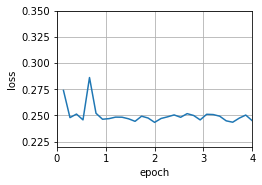

In [7]:
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.05}, data_iter)

loss: 0.252, 0.010 sec/epoch


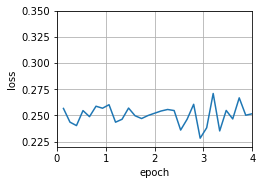

In [15]:
#T3 sample with replacement, 
data_iter_with_replacement = data.DataLoader(data_iter.dataset, 10, sampler=data.RandomSampler(torch.arange(len(data_iter.dataset)), True, len(data_iter.dataset)))
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.05}, data_iter_with_replacement)

loss: 0.257, 0.012 sec/epoch


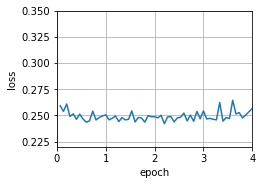

In [16]:
#T4
class DuplicateData(data.Dataset):
    def __init__(self, n) -> None:
        super().__init__()
        data = np.genfromtxt(download('airfoil'), dtype=np.float32, delimiter='\t')
        self.data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
        self.data = self.data[:n, :]
        self.n = n
    
    def __getitem__(self, idx):
        return self.data[idx%self.n, :-1], self.data[idx%self.n, -1]
    
    def __len__(self):
        return self.n

data_iter_duplicate = data.DataLoader(DuplicateData(1500), 10, sampler=data.RandomSampler(torch.arange(1500*2), False, 1500*2))
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.05}, data_iter_duplicate)

loss: 0.359, 0.066 sec/epoch


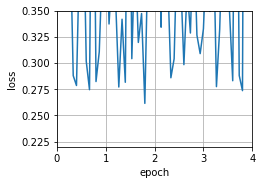

In [17]:
data_iter_duplicate = data.DataLoader(DuplicateData(1500), 1, sampler=data.RandomSampler(torch.arange(1500*2), False, 1500*2))
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.05}, data_iter_duplicate)

loss: 0.431, 0.045 sec/epoch


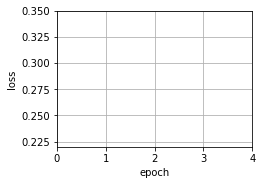

In [18]:
data_iter_duplicate = data.DataLoader(DuplicateData(1500), 3000, sampler=data.RandomSampler(torch.arange(1500*2), False, 1500*2))
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.05}, data_iter_duplicate)

## homework code for sec6

loss: 0.323, 0.014 sec/epoch


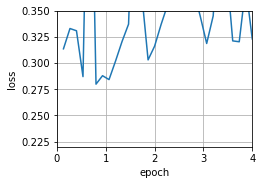

In [19]:
#T1
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.05, 'momentum': 0.9}, data_iter)

loss: 0.247, 0.011 sec/epoch


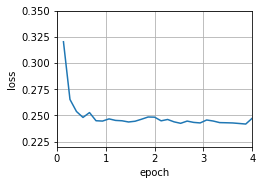

In [20]:
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.8}, data_iter)

loss: 0.243, 0.013 sec/epoch


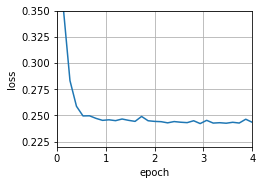

In [21]:
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.7}, data_iter)

loss: 0.242, 0.012 sec/epoch


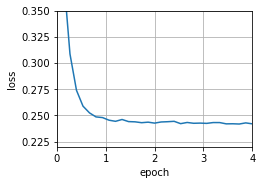

In [22]:
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.6}, data_iter)

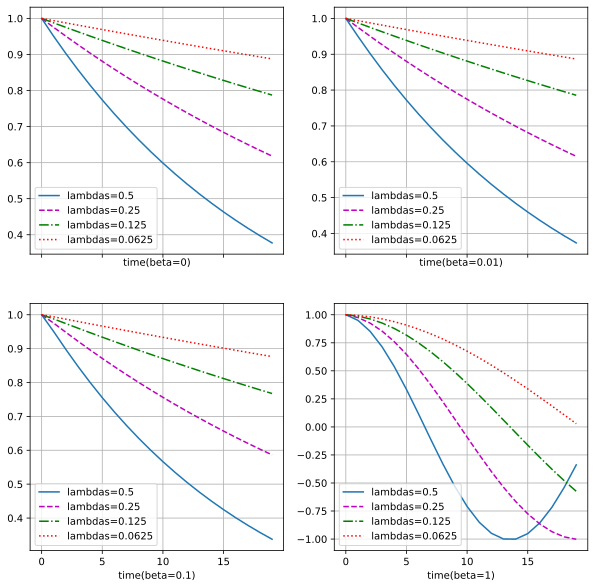

In [36]:
#T2
beta = [0, 0.01, 0.1, 1]
lambdas = [1/2**1, 1/2**2, 1/2**3, 1/2**4]
xlabels = [f'beta={beta[i]}' for i in range(4)]
eta = 0.1
x_cache = np.ones((4, 20), dtype=np.float32)
v_cache = np.zeros((4, 20), dtype=np.float32)
## iterate_according beta
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True)
axes = np.ravel(axes)
for i in range(4):
    for j in range(4):
        for k in range(19):
            v_cache[j, k+1] = beta[i]*v_cache[j,k]+lambdas[j]*x_cache[j,k]
            x_cache[j, k+1] = (1-eta*lambdas[j])*x_cache[j,k] - beta[i]*eta*v_cache[j,k]
    plot(list(range(20)), x_cache, xlabel=f'time({xlabels[i]})', legend=[f'lambdas={lambdas[j]}' for j in range(4)], axes=axes[i], figsize=(20, 20))

## homework code in sec6

epoch 20, x1: -0.001747, x2: -0.002392


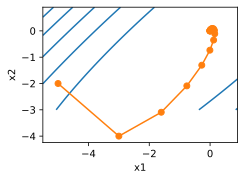

In [44]:
#T2
import math
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 4.2*x1 + 3.8*x2, -3.8*x1+4.2*x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * (x1 + x2) ** 2 + 2 * (x1-x2) ** 2

eta=2
show_trace_2d(f_2d, train_2d(adagrad_2d))

## homework code for sec8

epoch 20, x1: 0.003351, x2: 0.006156


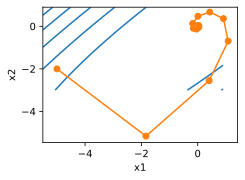

In [3]:
#T2
def rmsprop_2d(x1, x2, s1, s2, gamma):
    eps = 1e-6
    g1, g2 = 4.2*x1 + 3.8*x2, -3.8*x1+4.2*x2
    s1 = gamma*s1 + (1-gamma)*g1 ** 2
    s2 = gamma*s2 + (1-gamma)*g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2


def f_2d(x1, x2):
    return 0.1 * (x1 + x2) ** 2 + 2 * (x1-x2) ** 2

eta=1
show_trace_2d(f_2d, train_2d(partial(rmsprop_2d, gamma=0.9)))

## homework code for sec9

loss: 0.244, 0.013 sec/epoch


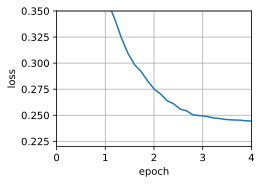

In [6]:
#T1
trainer = torch.optim.Adadelta
train_concise_ch11(trainer, {'rho': 0.8}, data_iter)

loss: 0.245, 0.012 sec/epoch


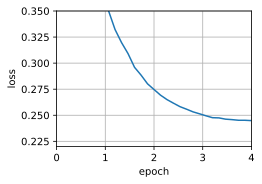

In [7]:
trainer = torch.optim.Adadelta
train_concise_ch11(trainer, {'rho': 0.7}, data_iter)

## homework code for sec10

loss: 0.267, 0.014 sec/epoch


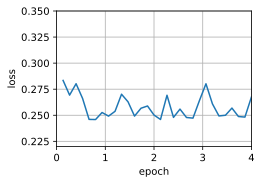

In [8]:
#t1
trainer = torch.optim.Adam
train_concise_ch11(trainer, {'lr': 0.05}, data_iter)

loss: 0.245, 0.014 sec/epoch


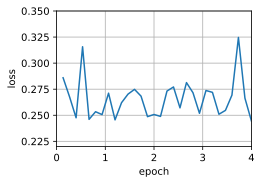

In [9]:
trainer = torch.optim.Adam
train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

loss: 0.244, 0.014 sec/epoch


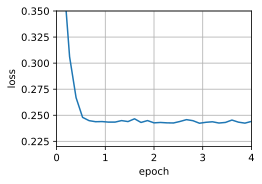

In [10]:
# 在nasa数据集中，小的学习率学习轨迹更加稳定
trainer = torch.optim.Adam
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

In [ ]:
#T2


## homework code for sec11

In [18]:
from torch.optim import lr_scheduler


def net_fn():
    m = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))
    return m

loss = nn.CrossEntropyLoss()
device = try_gpu()
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)


def train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler=None):
    net.to(device)
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs], legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        metric = Accumulator(3) # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                scheduler.step()
            else:
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')

train loss 0.169, train acc 0.938, test acc 0.888


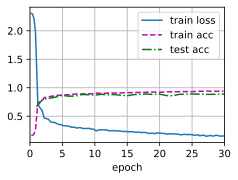

In [16]:
#T1
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

train loss 0.181, train acc 0.934, test acc 0.902


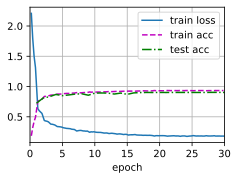

In [19]:
#T1
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)